# Enhancer CNN Training and Inference
## Importing Libraries and training the model

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
import gc
torch.manual_seed(42)
random.seed(42)

input_folder_list=list(glob('/kaggle/input/combination-dataset/Dehazenet_2L_RGB_TestDWT_Dehazenet_RGB_Test/*.png'))
target_folder_list=list(glob('/kaggle/input/combination-dataset/DWT_Dehazenet_RGB_Test/clear_image_*.png'))
target_folder_list.sort()
input_folder_list.sort()
batch_size=16
num_epochs=20
lr=1e-4
device="cuda" if torch.cuda.is_available() else "cpu"

class CustomDataset(Dataset):
    def __init__(self, input_folder, target_folder, transform=None):
        self.input_files=input_folder
        self.target_files=target_folder
        self.transform=transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_img=Image.open(self.input_files[idx]).convert('RGB')
        target_img=Image.open(self.target_files[idx]).convert('RGB')
        if self.transform:
            input_img=self.transform(input_img)
            target_img=self.transform(target_img)
        return input_img,target_img

class FinalCNN(nn.Module):
    def __init__(self):
        super(FinalCNN, self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv5=nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv6=nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv7=nn.Conv2d(in_channels=16,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu=nn.ReLU()

    def forward(self, x):
        x1=self.relu(self.conv1(x))
        x2=self.relu(self.conv2(x1))
        x3=self.relu(self.conv3(x2))
        x4=self.relu(self.conv4(x3))
        x5=self.relu(self.conv5(x4))+x3
        x6=self.relu(self.conv6(x5))+x1
        x7=self.relu(self.conv7(x6)) 
        return self.relu(x7*x-x7+1)

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

dataset=CustomDataset(input_folder_list,target_folder_list,transform=transform)
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)

model=FinalCNN().to(device)
model=nn.DataParallel(model)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=lr)

losses=[]
for epoch in tqdm(range(num_epochs)):
    model.train()  
    running_loss=0.0
    for inputs,targets in dataloader:
        inputs,targets=inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    losses.append(running_loss/len(dataloader))
    torch.cuda.empty_cache()
    gc.collect()
print('Finished Training')
torch.save(model.state_dict(),'end_cnn.pth')


  5%|▌         | 1/20 [00:12<04:05, 12.94s/it]

Epoch [1/20]


 10%|█         | 2/20 [00:20<02:54,  9.71s/it]

Epoch [2/20]


 15%|█▌        | 3/20 [00:27<02:24,  8.50s/it]

Epoch [3/20]


 20%|██        | 4/20 [00:34<02:05,  7.86s/it]

Epoch [4/20]


 25%|██▌       | 5/20 [00:41<01:52,  7.50s/it]

Epoch [5/20]


 30%|███       | 6/20 [00:48<01:42,  7.33s/it]

Epoch [6/20]


 35%|███▌      | 7/20 [00:55<01:33,  7.21s/it]

Epoch [7/20]


 40%|████      | 8/20 [01:02<01:26,  7.19s/it]

Epoch [8/20]


 45%|████▌     | 9/20 [01:09<01:18,  7.15s/it]

Epoch [9/20]


 50%|█████     | 10/20 [01:16<01:11,  7.19s/it]

Epoch [10/20]


 55%|█████▌    | 11/20 [01:23<01:04,  7.15s/it]

Epoch [11/20]


 60%|██████    | 12/20 [01:30<00:57,  7.13s/it]

Epoch [12/20]


 65%|██████▌   | 13/20 [01:37<00:49,  7.10s/it]

Epoch [13/20]


 70%|███████   | 14/20 [01:44<00:42,  7.11s/it]

Epoch [14/20]


 75%|███████▌  | 15/20 [01:52<00:35,  7.14s/it]

Epoch [15/20]


 80%|████████  | 16/20 [01:59<00:28,  7.13s/it]

Epoch [16/20]


 85%|████████▌ | 17/20 [02:06<00:21,  7.11s/it]

Epoch [17/20]


 90%|█████████ | 18/20 [02:13<00:14,  7.12s/it]

Epoch [18/20]


 95%|█████████▌| 19/20 [02:20<00:07,  7.16s/it]

Epoch [19/20]


100%|██████████| 20/20 [02:27<00:00,  7.39s/it]

Epoch [20/20]
Finished Training


## Observing the Loss curve

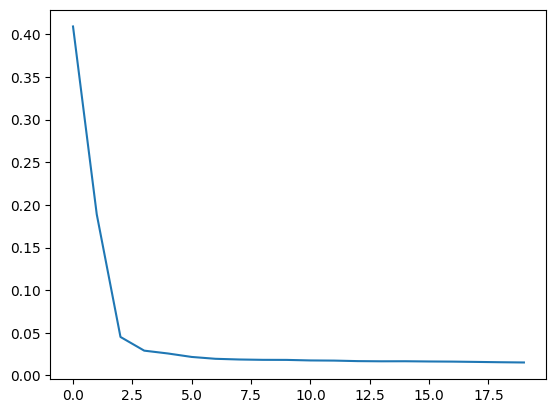

In [2]:
import matplotlib.pyplot as plt
plt.plot(losses)

## Inference on the Test dataset
This is the final step of the entire workflow. The metrics have been evaluated on the test dataset. 

In [3]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

psnr_fn = PeakSignalNoiseRatio()
ssim_fn = StructuralSimilarityIndexMeasure()

input_folder_list=list(glob('/kaggle/input/combination-dataset/Dehazenet_2L_RGB_TestDWT_Dehazenet_RGB_Test/*.png'))
target_folder_list=list(glob('/kaggle/input/combination-dataset/DWT_Dehazenet_RGB_Test/clear_image_*.png'))
target_folder_list.sort()
input_folder_list.sort()

model.eval()
psnr_li=[]
ssim_li=[]
for inp, clear in zip(input_folder_list,target_folder_list):
    clear_image=transforms.ToTensor()(cv2.cvtColor(cv2.imread(clear),cv2.COLOR_BGR2RGB))
    proc_image=transforms.ToTensor()(cv2.cvtColor(cv2.imread(inp),cv2.COLOR_BGR2RGB)).to(device)
    clear_image=clear_image.unsqueeze(0)
    proc_image=proc_image.unsqueeze(0)
    with torch.no_grad():
        model_proc=model(proc_image)
    psnr_value=psnr_fn(model_proc.cpu(), clear_image).item() 
    ssim_value=ssim_fn(model_proc.cpu(), clear_image).item()  
    psnr_li.append(psnr_value)
    ssim_li.append(ssim_value)

avg_psnr=sum(psnr_li)/len(psnr_li)
avg_ssim=sum(ssim_li)/len(ssim_li)
print(f"PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")


PSNR: 18.9468, SSIM: 0.7689
